(572, 380)
torch.Size([1, 3, 380, 572])


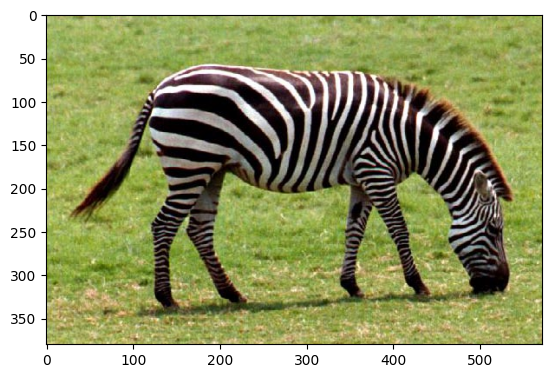

In [1]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

torch.cuda.set_device(9)

device = torch.device('cuda') 

zebra_img = Image.open("database/zebra.png")
# zebra_img = Image.open("output/zebra_random_sample.png")
print(zebra_img.size)
preprocess = transforms.Compose([
   transforms.ToTensor(),
])
zebra_tensor = preprocess(zebra_img)[None,:,:,:]

print(zebra_tensor.shape)
plt.imshow(zebra_tensor[0].numpy().transpose(1,2,0));

In [2]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.to(device)
model.eval();

/cis/home/tlu32/anaconda3/envs/GPNN/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/cis/home/tlu32/anaconda3/envs/GPNN/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
pred = model(norm(zebra_tensor).to(device))

In [5]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

print(imagenet_classes[pred.max(dim=1)[1].item()])

zebra


In [5]:
import torch.optim as optim
epsilon = 0.05 # 0 to 0.5 20 images

delta = torch.zeros_like(zebra_tensor, requires_grad=True)
opt = optim.Adam([delta], lr=1e-3)

for t in range(100):
    pred = model(norm(zebra_tensor + delta).to(device))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([340]).to(device))
    if t % 5 == 0:
        print(t, "Loss =", loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,340].item())

0 Loss = -0.16548651456832886
5 Loss = -5.003536224365234
10 Loss = -8.675140380859375
15 Loss = -13.048954010009766
20 Loss = -18.8576602935791
25 Loss = -24.687145233154297
30 Loss = -29.93906593322754
35 Loss = -34.308719635009766
40 Loss = -38.06929016113281
45 Loss = -41.378021240234375
50 Loss = -44.12082290649414
55 Loss = -46.485416412353516
60 Loss = -48.4847526550293
65 Loss = -50.12546157836914
70 Loss = -51.499000549316406
75 Loss = -52.65935134887695
80 Loss = -53.67380142211914
85 Loss = -54.579925537109375
90 Loss = -55.36369323730469
95 Loss = -56.07931900024414
True class probability: 2.6048650546179627e-25


Predicted class:  croquet_ball
Predicted probability: 1.0
1.01 -0.01


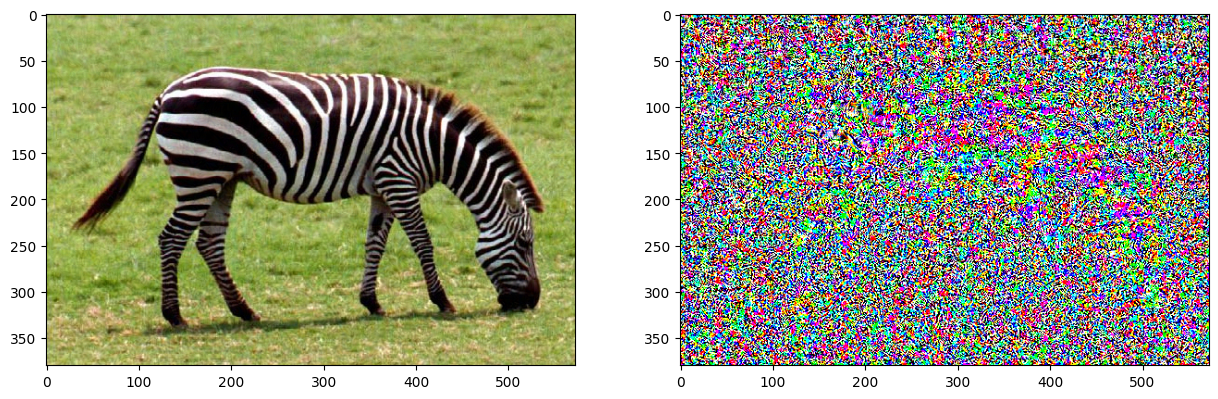

In [6]:
pred = model(norm(zebra_tensor + delta).to(device))
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
result = (zebra_tensor+delta)[0].detach().numpy().transpose(1,2,0)
print(result.max(), result.min())
# clip to 0.0-1.0
result = np.clip(result, 0.0, 1.0)

plt.imsave("./perturbed_img/zebra_perturbed.png", result)

fig, axes = plt.subplots(1,2, figsize=(15,15))

axes[0].imshow(result)
axes[1].imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0));

In [8]:
%%time
! for i in {1..10}; do CUDA_VISIBLE_DEVICES=9 python random_sample.py -in perturbed_img/zebra_perturbed.png -out_index $i --faiss; done 

cuda initialized!
faiss initialized!
/cis/home/tlu32/projects/GPNN/model/gpnn.py:56: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  tuple(pyramid_gaussian(self.input_img, pyramid_depth, downscale=self.R, multichannel=True)))
cuda initialized!
faiss initialized!
/cis/home/tlu32/projects/GPNN/model/gpnn.py:56: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  tuple(pyramid_gaussian(self.input_img, pyramid_depth, downscale=self.R, multichannel=True)))
cuda initialized!
faiss initialized!
/cis/home/tlu32/projects/GPNN/model/gpnn.py:56: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  tuple(pyramid_gaussian(self.input_img, pyramid_depth, downscale=self.R, multichannel=True))

In [6]:
for i in range(1,11):
    zebra_perturbed_img = Image.open(f"output/zebra_perturbed_random_sample_{i}.png")
    zebra_perturbed_tensor = preprocess(zebra_perturbed_img)[None,:,:,:]
    pred = model(norm(zebra_perturbed_tensor).to(device))
    print(imagenet_classes[pred.max(dim=1)[1].item()])

croquet_ball
croquet_ball
croquet_ball
zebra
croquet_ball
zebra
zebra
zebra
croquet_ball
zebra
